setup:

* pip install ipython-autotime
* pip install pyenchant

In [1]:
import nltk
# nltk.download() #punkt

In [28]:
%load_ext autotime
%pylab inline
from __future__ import unicode_literals
import pandas as pd
import multiprocessing as mp
# from nltk.tokenize.stanford import StanfordTokenizer
import sys, re, json, csv, time, pickle
sys.path.append('quora-duplicates/')
import enchant
from enchant.checker import SpellChecker
# from utils.spellcheck import spell_check

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
Populating the interactive namespace from numpy and matplotlib
time: 137 ms


/Users/kyu/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [29]:
print 'loading data...'
quora = pd.read_csv('data/quora_duplicate_questions.tsv', sep='\t', encoding='utf-8')
print quora.shape
quora.head(2)

loading data...
(404351, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


time: 3.9 s


In [4]:
quora.is_duplicate.value_counts()/float(quora.shape[0])

0    0.630752
1    0.369248
Name: is_duplicate, dtype: float64

time: 8.25 ms


## Spell-checker

In [5]:
# https://www.packtpub.com/mapt/book/application-development/9781782167853/2/ch02lvl1sec23/spelling-correction-with-enchant
import enchant
from nltk.metrics import edit_distance

class SpellingReplacer(object):
  def __init__(self, dict_name='en', max_dist=2):
    self.spell_dict = enchant.Dict(dict_name)
    self.max_dist = max_dist

  def replace(self, words):
    corrected_words = list()
    for word in words:
        if self.spell_dict.check(word):
            corrected_words.append(word)
            continue
        suggestions = self.spell_dict.suggest(word)
        if suggestions and edit_distance(word, suggestions[0]) <= self.max_dist:
          corrected_words.append(suggestions[0])
        else:
          corrected_words.append(word)
    return corrected_words

time: 8.65 ms


In [6]:
replacer = SpellingReplacer()

time: 31.4 ms


## Tokenizations

In [7]:
# define tokenizer
# jar_path = '/Users/katherineyu/tools/stanford-postagger-2016-10-31/stanford-postagger.jar'
# model_path = '/Users/katherineyu/tools/stanford-postagger-2016-10-31/models/english-bidirectional-distsim.tagger'
# tokenizer = StanfordTokenizer(path_to_jar=jar_path, encoding='utf8', options=None, verbose=True, java_options='-mx2000m')
# print tokenizer.tokenize('Hello world.')

time: 1.53 ms


In [7]:
# load glove pretrained vectors
gl = pd.read_csv('glove/glove.6B.100d.txt', header=None, sep='\s+', error_bad_lines=False, quoting=csv.QUOTE_NONE, encoding='utf8')
gl_vocab = gl.pop(0)
gl_vocab_index = pd.DataFrame({'vocab_idx': gl_vocab.index})
gl_vocab_index.index = gl_vocab.values
print gl_vocab.shape, gl.shape
gl_vocab_index.head(5)

(400000,) (400000, 100)


,vocab_idx
the,0
",",1
.,2
of,3
to,4


time: 10.7 s


In [8]:
from nltk.tokenize.stanford import StanfordTokenizer
from nltk.tokenize import word_tokenize
import string
class TokenizerWorker(object):
    
    def __init__(self, gl_vocab_index, gl, spellreplacer):
#         self.tokenizer = tokenizer
        self.gl_vocab_index = gl_vocab_index
        self.gl = gl
        self.spellreplacer = spellreplacer
    
    def tokenize(self, s):
#         tokens = self.tokenizer.tokenize(s)
#         tokens =  re.findall(r"[\w']+", s)
        try:
            s = re.sub(r'[^\w\s]','', s.encode('utf-8').lower())
        except:
            return [s]
        tokens = word_tokenize(s) # lower and strip punctuation
        tokens_postprocess = tokens
        return tokens_postprocess
    
    def __call__(self, s):

        tokens = self.tokenize(s)
        s_vect = np.zeros((1, self.gl.shape[1]))
        missing_word = False
        
        for word in tokens: # sum glove vectors
            try:
                s_vect += self.gl.iloc[self.gl_vocab_index.ix[word], :]
            except KeyError:
                missing_word = True
            except TypeError:
                continue
        
        if missing_word: # rerun with spellcheck
            tokens = self.spellreplacer.replace(tokens)
            s_vect = np.zeros((1, self.gl.shape[1]))
            for word in tokens:
                try:
                    s_vect += self.gl.iloc[self.gl_vocab_index.ix[word], :]
                except (KeyError, TypeError) as e:
                    pass
            s = ' '.join(tokens)

        return (s, s_vect)

time: 23.9 ms


In [14]:
# test the token match without spell_check
n = 100
match_ct = 0
nonmatch_ct = 0
tot_nonmatch_ct = 0

tokenizer_worker = TokenizerWorker(gl_vocab_index, gl, replacer)
for s in quora['question1'].values[:n]:
    s_vect = np.zeros((1, gl.shape[1]))
    tokens = tokenizer_worker.tokenize(s)
    has_match = False
    for word in tokens:
        if word in gl_vocab_index.index:
            s_vect += gl.iloc[gl_vocab_index.ix[word], :]
            match_ct += 1
            has_match = True
        else:
            nonmatch_ct += 1
            print s
            print word
    if not has_match:
        tot_nonmatch_ct += 1
print match_ct, nonmatch_ct, nonmatch_ct/(match_ct + nonmatch_ct + 0.0), tot_nonmatch_ct

Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?
quikly
Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
risingwhat
Motorola (company): Can I hack my Charter Motorolla DCX3400?
motorolla
Motorola (company): Can I hack my Charter Motorolla DCX3400?
dcx3400
Method to find separation of slits using fresnel biprism?
biprism
I'm a 19-year-old. How can I improve my skills or what should I do to become an entrepreneur in the next few years?
19yearold
What universities does Rexnord recruit new grads from? What majors are they looking for?
rexnord
What is the best/most memorable thing you've ever eaten and why?
bestmost
What is the best/most memorable thing you've ever eaten and why?
youve
Who is israil friend?
israil
How do I download content from a kickass torrent without registration?
kickass
What were the major effects of the cambodia earthquake, and how do these effects compare to the Kamchatca earthquakes in 1952?
kamchatca

In [9]:
# test spellcheck
input1 = "Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?"
tokenizer_worker = TokenizerWorker(gl_vocab_index, gl, replacer)
replacer.replace(tokenizer_worker.tokenize(input1))

[u'which',
 u'one',
 u'dissolve',
 u'in',
 u'water',
 u'quickly',
 u'sugar',
 u'salt',
 u'methane',
 u'and',
 u'carbon',
 u'id',
 u'oxide']

time: 107 ms


In [10]:
# test run
replacer = SpellingReplacer()
tokenizer_worker = TokenizerWorker(gl_vocab_index, gl, replacer)
zip(*quora.question1[:10000].map(tokenizer_worker))

In [11]:
# Tokenize question 1 and question 2
cpu_ct = mp.cpu_count(); print cpu_ct
pool = mp.pool.Pool(cpu_ct)

tokenizer_worker = TokenizerWorker(gl_vocab_index, gl, replacer)

print 'tokenizing question 1'
tok_question1 = pool.map(tokenizer_worker, quora.question1)
print 'done'

print 'saving tokenization...'
with open('data/tokenized_question1_%s.pkl' % time.time(), 'w') as f:
    pickle.dump(tok_question1, f)


print 'tokenizing question 2'
tok_question2 = pool.map(tokenizer_worker, quora.question2)
print 'done'

print 'saving tokenization...'
with open('data/tokenized_question2_%s.pkl' % time.time(), 'w') as f:
    pickle.dump(tok_question2, f)


pool.close()

8
tokenizing question 1
done
saving tokenization...
tokenizing question 2
done
saving tokenization...
time: 44min 53s


In [24]:
# munge tokenizations
wv1 = zip(*tok_question1)[1] 
emb_q1 = np.vstack(wv1)
print emb_q1.shape

wv2 = zip(*tok_question2)[1] 
emb_q2 = np.vstack(wv2)
print emb_q2.shape

emb_q1q2 = np.hstack((emb_q1, emb_q2)) 
print emb_q1q2.shape

(404351, 100)
(404351, 100)
time: 4.4 s


In [28]:
# save tokenization as numpy array
np.savetxt("data/embedding_q1q2_%s.csv" % time.time(), emb_q1q2, delimiter=",")

time: 1min 14s


In [ ]:
# tokenizer_worker = TokenizerWorker(tokenizer, gl_vocab_index, gl, replacer)
# quora.question2.map(tokenizer_worker)

In [33]:
with open('data/tokenized_question1_1486096656.54.pkl') as f:
    tok_question1 = pickle.load(f)
with open('data/tokenized_question2_1486103937.45.pkl') as f:
    tok_question2 = pickle.load(f)

time: 2min 14s


In [18]:
from sklearn.cross_validation import train_test_split
q1_train, q2_train, q1_test, q2_test, ytrain, ytest = train_test_split(tok_question1, tok_question2, quora.is_duplicate.values)

time: 348 ms


In [19]:
train_sim = [cosine_similarity(q1_train[i][1], q2_train[i][1])[0,0] for i in range(10000)]
ytrain = ytrain[:10000]

time: 1.46 s


In [20]:
train_sim = np.array(train_sim)

time: 1.67 ms


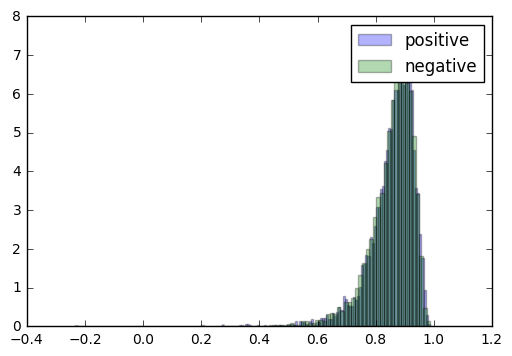

time: 761 ms


In [21]:
plt.hist(train_sim[np.where(ytrain==1)[0]], normed=True, alpha=0.3, label='positive', bins=100)
plt.hist(train_sim[np.where(ytrain==0)[0]], normed=True, alpha=0.3, label='negative', bins=100)
plt.legend();

In [34]:
thres = 0.85
pred = train_sim > thres
p = sum(np.logical_and(pred==1, ytrain==1)) / float(sum(pred))
r = sum(np.logical_and(pred==1, ytrain==1)) / float(sum(ytrain==1))
print p, r, 2*p*r/(p+r)

0.377379983727 0.625235912645 0.470671808403
time: 51.7 ms


In [8]:
# validation that word vectors are close
from sklearn.metrics.pairwise import cosine_similarity
for i in range(100):
    print tok_question2[i][0], tok_question1[i][0]
    print cosine_similarity(tok_question2[i][1], tok_question1[i][1])[0,0], quora.is_duplicate.values[i]

What is the step by step guide to invest in share market? What is the step by step guide to invest in share market in india?
0.994985474829 0
What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back? What is the story of Kohinoor (Koh-i-Noor) Diamond?
0.890191977161 0
How can Internet speed be increased by hacking through DNS? How can I increase the speed of my internet connection while using a VPN?
0.961039587557 0
find the remainder when math2324math is divided by 2423 Why am I mentally very lonely? How can I solve it?
0.817308079324 0
Which fish would survive in salt water? which one dissolve in water quickly sugar salt methane and carbon id oxide
0.919948337727 0
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me? astrology I am a Capricorn sun cap moon and cap rising what does that say about me
0.964879978034 1
what keeps children active and far from phone and video games Should I buy tiago?
0.781134639535 0
Wha

In [ ]:
# string featurizations (shingling, jacquard), character deeplearning byte-pair encoding, snli
# specific first architecture: lstm with attention

## conll format

In [30]:
from nltk.tokenize import word_tokenize
from enchant.checker import SpellChecker


EOS_CHAR = 'zzzz'

time: 1.82 ms


In [11]:
print 'loading data...'
quora = pd.read_csv('data/quora_duplicate_questions.tsv', sep='\t', encoding='utf-8')
print quora.shape
quora.head(2)

loading data...
(404351, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


time: 1.2 s


In [31]:
# replacer = SpellingReplacer()
np.random.seed(0)

def tokenize_quora_row(row, file_dict):
    # tokenize
    try:
        q1_tok = word_tokenize(row['question1'])
        q2_tok = word_tokenize(row['question2'])
        conll_entry_a = '\n'.join(q1_tok) + '\n\n'
        conll_entry_a = conll_entry_a.encode('utf-8')
        conll_entry_b = '\n'.join(q2_tok) + '\n\n'
        conll_entry_b = conll_entry_b.encode('utf-8')        
        label_entry = str(row['is_duplicate'])+'\n'
    except:  # encoding errors, not str, etc.
        return
    
    # split train/dev/test
    x = np.random.random()
    if x < .6:
        k = 'train'
    elif x < .8:
        k = 'dev'
    else: 
        k = 'test'
    
    # write
    fa, fb, flab = file_dict[k]['fa'], file_dict[k]['fb'], file_dict[k]['flab']
    fa.write(conll_entry_a)
    fb.write(conll_entry_b)
    flab.write(label_entry)


time: 17.1 ms


In [53]:
# tokenize conll
with open('data/dat_train_a.conll', 'w') as trainaf:
    with open('data/dat_train_b.conll', 'w') as trainbf:
        with open('data/labels_train.conll', 'w') as trainlabelf:
            with open('data/dat_dev_a.conll', 'w') as devaf:
                with open('data/dat_dev_b.conll', 'w') as devbf:
                    with open('data/labels_dev.conll', 'w') as devlabelf:        
                        with open('data/dat_test_a.conll', 'w') as testaf:
                            with open('data/dat_test_b.conll', 'w') as testbf:
                                with open('data/labels_test.conll', 'w') as testlabelf:
                                    file_dict = {
                                        'train': {'fa': trainaf, 'fb': trainbf, 'flab': trainlabelf},
                                        'dev': {'fa': devaf, 'fb': devbf, 'flab': devlabelf},
                                        'test': {'fa': testaf, 'fb': testbf, 'flab': testlabelf}
                                    }
                                    tok_conll = quora.apply(lambda x: tokenize_quora_row(x, file_dict), axis=1)

time: 2min 40s


In [32]:
# tokenize conll small
with open('data/sm_dat_train_a.conll', 'w') as trainaf:
    with open('data/sm_dat_train_b.conll', 'w') as trainbf:
        with open('data/sm_labels_train.conll', 'w') as trainlabelf:
            with open('data/sm_dat_dev_a.conll', 'w') as devaf:
                with open('data/sm_dat_dev_b.conll', 'w') as devbf:
                    with open('data/sm_labels_dev.conll', 'w') as devlabelf:        
                        with open('data/sm_dat_test_a.conll', 'w') as testaf:
                            with open('data/sm_dat_test_b.conll', 'w') as testbf:
                                with open('data/sm_labels_test.conll', 'w') as testlabelf:
                                    file_dict = {
                                        'train': {'fa': trainaf, 'fb': trainbf, 'flab': trainlabelf},
                                        'dev': {'fa': devaf, 'fb': devbf, 'flab': devlabelf},
                                        'test': {'fa': testaf, 'fb': testbf, 'flab': testlabelf}
                                    }
                                    tok_conll = quora.head(5000).apply(lambda x: tokenize_quora_row(x, file_dict), axis=1)

time: 2.35 s
